<a href="https://colab.research.google.com/github/rimazzz/Gender-Voice-Classifier/blob/main/voice_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install noisereduce

In [ ]:
from glob import glob
import numpy
import scipy
import math
import matplotlib
import noisereduce
import librosa
import pathlib
import sklearn
from IPython.display import Audio
import copy
import sklearn.linear_model

In [ ]:
male_audio_files = list(pathlib.Path('/content/drive/MyDrive/Actors/male').glob("*.wav"))
female_audio_files = list(pathlib.Path('/content/drive/MyDrive/Actors/female').glob("*.wav"))
# Play audio
Audio(male_audio_files[0])

In [ ]:
print(len(male_audio_files))
print(len(female_audio_files))

681
239


In [ ]:
frame_rate, signal = scipy.io.wavfile.read(male_audio_files[0])
print(f"Frame Rate: {frame_rate}")

Frame Rate: 48000


<ipython-input-6-279f91ea392f>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  frame_rate, signal = scipy.io.wavfile.read(male_audio_files[0])


In [ ]:
def draw_signal(signal):
  matplotlib.pyplot.plot(signal)
  matplotlib.pyplot.show()

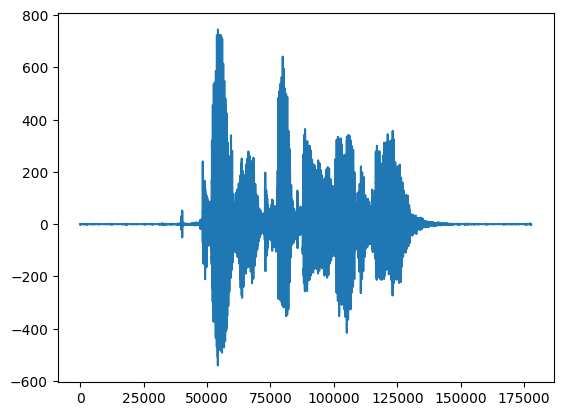

In [ ]:
draw_signal(signal)

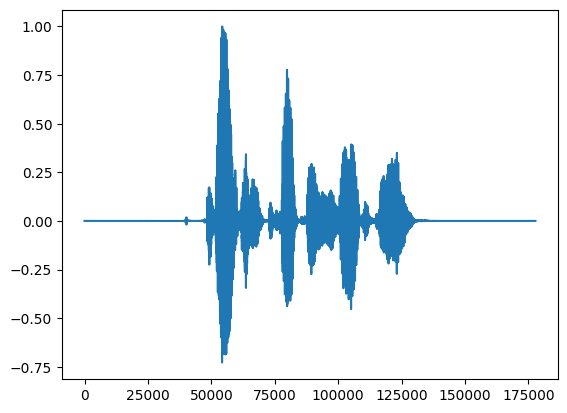

In [ ]:
# Remove DC offset
processed_signal = signal - numpy.mean(signal)
# Noise Reduction
processed_signal  = noisereduce.reduce_noise(y=processed_signal, sr=frame_rate)
# amplitude normalization
processed_signal = processed_signal / numpy.max(numpy.abs(processed_signal))

draw_signal(processed_signal)

In [ ]:
Audio(data=processed_signal, rate=frame_rate)

In [ ]:
class AudioFeatures:
  def __init__(self, wav_file, n_mfcc=20):
    self.load(wav_file)
    self.n_mfcc = n_mfcc
    # features
    # all features applies on the whole audio sample
    self.MFCC: numpy.ndarray = self.get_MFCC()
    self.spectral_centroid: float  = self.get_spectral_centroid()
    self.spectral_rolloff: float = self.get_spectral_rolloff()
    self.spectral_bandwidth: float = self.get_spectral_bandwidth()
    self.spectral_flux: float = self.get_spectral_flux()
    self.zero_crossing_rate: float = self.get_zero_crossing_rate()
    self.spectral_flatness: float = self.get_spectral_flatness()
  def load(self, wav_file):
    try:
        self.signal, self.frame_rate = librosa.load(wav_file, sr=None)  # sr=None keeps original sample rate
        self.signal = librosa.util.normalize(self.signal)  # Peak normalization

        # Remove DC offset (center signal around 0)
        self.signal = self.signal - numpy.mean(self.signal)

        # Noise reduction (skip if the signal is too short)
        if len(self.signal) > 2048:
            self.signal = noisereduce.reduce_noise(
                y=self.signal,
                sr=self.frame_rate,
                stationary=True
            )
        else:
            print(f"Warning: File {wav_file} too short for noise reduction.")

        # Ensure signal is not empty
        if len(self.signal) == 0:
            raise ValueError("Empty signal after preprocessing.")

        # Update sample count
        self.n_samples = len(self.signal)

    except Exception as e:
        raise ValueError(f"Failed to load {wav_file}: {str(e)}")

  def get_MFCC(self):
    return librosa.feature.mfcc(y=self.signal, sr=self.frame_rate, n_mfcc=self.n_mfcc, n_fft=self.n_samples, hop_length=self.n_samples)
  def get_spectral_centroid(self):
    return librosa.feature.spectral_centroid(y=self.signal, sr=self.frame_rate, n_fft=self.n_samples, hop_length=self.n_samples)[0]
  def get_spectral_rolloff(self):
    return librosa.feature.spectral_rolloff(y=self.signal, sr=self.frame_rate, n_fft=self.n_samples, hop_length=self.n_samples)[0]
  def get_spectral_bandwidth(self):
    return librosa.feature.spectral_bandwidth(y=self.signal, sr=self.frame_rate, n_fft=self.n_samples, hop_length=self.n_samples)[0]
  def get_spectral_flux(self):
    return librosa.onset.onset_strength(y=self.signal, sr=self.frame_rate, n_fft=self.n_samples, hop_length=self.n_samples)[0]
  def get_zero_crossing_rate(self):
    return librosa.feature.zero_crossing_rate(y=self.signal, frame_length=self.n_samples, hop_length=self.n_samples)[0]
  def get_spectral_flatness(self):
    return librosa.feature.spectral_flatness(y=self.signal, n_fft=self.n_samples, hop_length=self.n_samples)[0]
  def features_ndarrays(self):
    output: list = list()
    for sample in self.MFCC:
      output.append(sample[0])
    output.append(self.spectral_centroid[0])
    output.append(self.spectral_rolloff[0])
    output.append(self.spectral_bandwidth[0])
    output.append(float(self.spectral_flux))
    output.append(self.zero_crossing_rate[0])
    output.append(self.spectral_flatness[0])
    return numpy.array(output)

In [ ]:
#Classes names
targets_names = ["male", "female"]

In [ ]:
features = list()
targets = list()

print("Processing Male Voices: ")
counter = 0
for file in male_audio_files:
  audio_features = AudioFeatures(file)
  features.append(audio_features.features_ndarrays())
  targets.append(targets_names.index("male"))
  print(f"\tProcessed: {file}")

print("Processing Female voices: ")
counter = 0
for file in female_audio_files:
  audio_features = AudioFeatures(file)
  features.append(audio_features.features_ndarrays())
  targets.append(targets_names.index("female"))
  print(f"\tProcessed: {file}")


Processing Male Voices: 
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-02-01-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-01-01-02-02-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-01-02-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-01-01-02-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-01-02-02-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-01-01-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-01-01-01-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-01-01-02-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-01-01-01-02-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-03-01-02-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-04-01-02-01-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-02-02-02-02-01.wav
	Processed: /content/drive/MyDrive/Actors/male/03-01-04-02-01-02-01.wav
	Processed: /content/drive/MyDrive/Acto

In [ ]:
features = numpy.array(features)
targets = numpy.array(targets)
print(features.shape)
print(targets.shape)

(920, 26)
(920,)


In [ ]:
# split train, test
features_train, features_test, targets_train, targets_test = sklearn.model_selection.train_test_split(features, targets, test_size=0.2)
print(features_train.shape)
print(features_test.shape)
print(targets_train.shape)
print(targets_test.shape)

(736, 26)
(184, 26)
(736,)
(184,)


In [ ]:
class NaiveBayesClassifier:
  def __init__(self):
    self.features = None
    self.targets = None
    self.classes = None
    # bayes parameters
    self.mean: list = list()
    self.variance: list = list()
    self.prior: list = list()
  def normal_distribution(self, input, mean, variance):
    if variance == 0:
      return 1
    return (1 / (numpy.sqrt(2 * numpy.pi * variance))) * numpy.exp(-((input - mean) ** 2) / (2 * variance))
  def fit(self, features, targets):
    self.features = features
    self.targets = targets
    self.classes = numpy.unique(self.targets)
    self.mean = list()
    self.variance = list()
    self.prior = list()
    for target_class in self.classes:
      self.mean.append(numpy.mean(self.features[self.targets == target_class], axis=0))
      self.variance.append(numpy.var(self.features[self.targets == target_class], axis=0))
      self.prior.append(numpy.mean(self.targets == target_class))
  def predict(self, sample:numpy.ndarray):
    output = list()
    # handle shape, convert shape (1, n) to (n,)
    if len(sample.shape) == 2:
      sample = sample[0]

    for target_class_index in range(len(self.classes)):
      target_class = self.classes[target_class_index]
      prior = self.prior[target_class_index]
      mean = self.mean[target_class_index]
      variance = self.variance[target_class_index]
      likelihood = 1
      for feature in range(len(sample)):
        likelihood *= self.normal_distribution(sample[feature], mean[feature], variance[feature])
      output.append(prior * likelihood)

    return self.classes[numpy.argmax(output)]
  def full_predict(self, samples: numpy.ndarray):
    output = list()
    for sample in samples:
      output.append(self.predict(sample))
    return numpy.array(output)


In [ ]:
# evaluate using our naive bayes class
naive_bayes = NaiveBayesClassifier()
naive_bayes.fit(features_train, targets_train)

In [ ]:
naive_bayes_predictions = naive_bayes.full_predict(features_test)

In [ ]:
print(naive_bayes.mean)
print(naive_bayes.variance)
print(naive_bayes.prior)
print(naive_bayes.classes)

[array([ 6.51306618e+01,  1.03933390e+02, -4.92460088e+01,  2.53380597e+01,
       -4.58931058e+01, -3.61827471e+00, -4.05556746e+01, -5.75357517e+00,
       -2.63559226e+01, -4.86098055e+00, -2.34785110e+01, -1.26851931e+01,
       -1.04196867e+01, -9.44590982e-01, -1.27080867e+01,  5.60000895e-01,
       -8.54661294e+00, -4.74295971e+00, -1.18500052e+01, -5.55033442e+00,
        4.04590559e+03,  8.17071748e+03,  4.04357343e+03,  0.00000000e+00,
        1.42981101e-01,  5.40794314e-03]), array([ 6.00554490e+01,  6.96550996e+01, -5.44046549e+01,  1.49608789e+01,
       -6.36967016e+01, -3.34069966e+00, -4.21465649e+01, -1.27533014e+00,
       -3.14823387e+01, -1.59153236e+01, -2.93159784e+01, -7.62391042e+00,
       -1.27522177e+01, -7.09055347e+00, -1.76085314e+01, -5.13401386e-01,
       -1.02283364e+01, -2.16668956e+00, -1.01645550e+01, -4.12669571e+00,
        5.06761810e+03,  9.98154927e+03,  4.46698262e+03,  0.00000000e+00,
        9.31747493e-02,  4.67641393e-03])]
[array([2.754

In [ ]:
print(naive_bayes_predictions)

[0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0]


In [ ]:
class BaggingEnsembleClassifier:
  def __init__(self, base_estimator, n_estimators=10):
    self.base_estimator = base_estimator
    self.n_estimators = n_estimators
    self.estimators = list()
  def resample(self, features, targets):
    features_sample = list()
    targets_sample = list()
    for _ in range(len(features)):
      index = numpy.random.randint(0, len(features))
      features_sample.append(features[index])
      targets_sample.append(targets[index])
    return numpy.array(features_sample), numpy.array(targets_sample)
  def fit(self, features, targets):
    for estimator_index in range(self.n_estimators):
      features_sample, targets_sample = self.resample(features, targets)
      estimator = copy.deepcopy(self.base_estimator)
      estimator.fit(features_sample, targets_sample)
      self.estimators.append(estimator)
  def predict(self, sample):
    output = list()
    # handle shape if sample shape is (n,) convert to (1, n)
    if len(sample.shape) == 1:
      sample = sample[numpy.newaxis, :]
    for estimator in self.estimators:
      estimator_result = estimator.predict(sample)
      # if estimator_result is of shape is like array convert to single element value
      if len(estimator_result.shape) == 1 and estimator_result.shape[0] == 1:
        estimator_result = estimator_result[0]
      output.append(estimator_result)
    return numpy.bincount(numpy.array(output)).argmax()
  def full_predict(self, samples):
    output = list()
    for sample in samples:
      output.append(self.predict(sample))
    return numpy.array(output)

In [ ]:
# test Naive Bayes Bagging
naive_bayes_bagging = BaggingEnsembleClassifier(NaiveBayesClassifier(), 50)
naive_bayes_bagging.fit(features_train, targets_train)

In [ ]:
naive_bayes_bagging_predictions = naive_bayes_bagging.full_predict(features_test)

In [ ]:
# built in Logistic Regressor Bagging
logistic_regression_bagging = BaggingEnsembleClassifier(sklearn.linear_model.LogisticRegression(), 50)
logistic_regression_bagging.fit(features_train, targets_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
logistic_regression_bagging_predictions = logistic_regression_bagging.full_predict(features_test)

In [ ]:
print("Naive Bayes Single Object: ")
print("accuracy: ", sklearn.metrics.accuracy_score(targets_test, naive_bayes_predictions))
print("precision: ", sklearn.metrics.precision_score(targets_test, naive_bayes_predictions))
print("recall: ", sklearn.metrics.recall_score(targets_test, naive_bayes_predictions))
print("f1: ", sklearn.metrics.f1_score(targets_test, naive_bayes_predictions))

Naive Bayes Single Object: 
accuracy:  0.8641304347826086
precision:  0.6981132075471698
recall:  0.8043478260869565
f1:  0.7474747474747475


In [ ]:
print("Naive Bayes Bagging Ensemble: ")
print("accuracy: ", sklearn.metrics.accuracy_score(targets_test, naive_bayes_bagging_predictions))
print("precision: ", sklearn.metrics.precision_score(targets_test, naive_bayes_bagging_predictions))
print("recall: ", sklearn.metrics.recall_score(targets_test, naive_bayes_bagging_predictions))
print("f1: ", sklearn.metrics.f1_score(targets_test, naive_bayes_bagging_predictions))

Naive Bayes Bagging Ensemble: 
accuracy:  0.8532608695652174
precision:  0.6938775510204082
recall:  0.7391304347826086
f1:  0.7157894736842105


In [ ]:
print("Logistic Regression Bagging Ensemble: ")
print("accuracy: ", sklearn.metrics.accuracy_score(targets_test, logistic_regression_bagging_predictions))
print("precision: ", sklearn.metrics.precision_score(targets_test, logistic_regression_bagging_predictions))
print("recall: ", sklearn.metrics.recall_score(targets_test, logistic_regression_bagging_predictions))
print("f1: ", sklearn.metrics.f1_score(targets_test, logistic_regression_bagging_predictions))

Logistic Regression Bagging Ensemble: 
accuracy:  0.8858695652173914
precision:  0.711864406779661
recall:  0.9130434782608695
f1:  0.8
